In [5]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

# Configurar las opciones de visualización de pandas (opcional)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Función para limpiar columnas numéricas
def clean_numeric_column(column):
    column_as_str = column.astype(str).str.replace(',', '').str.replace('$', '').str.strip()
    return pd.to_numeric(column_as_str, errors='coerce')


# Cargar los conjuntos de datos
ruta_train = 'C:/Users/Marcio Pineda/Documents/Archivos Python/datasets/traincase.csv'
ruta_test = 'C:/Users/Marcio Pineda/Documents/Archivos Python/datasets/testcase.csv'
df_train = pd.read_csv(ruta_train)
df_test = pd.read_csv(ruta_test)

# Asegurarse de que 'Match Type' esté presente en los conjuntos de datos
assert 'Match Type' in df_train.columns, "La columna 'Match Type' no está presente en el conjunto de entrenamiento."
assert 'Match Type' in df_test.columns, "La columna 'Match Type' no está presente en el conjunto de prueba."

# Marcar los conjuntos de datos para poder distinguirlos después de la concatenación
df_train['set'] = 'Not Kaggle'
df_test['set'] = 'Kaggle'

# Concatenar df_train y df_test en df_full
df_full = pd.concat([df_train, df_test], ignore_index=True)

# Aplicar la función de limpieza a las columnas numéricas relevantes en df_full
columns_to_clean = ['Search Engine Bid', 'Impressions', 'Avg. Cost per Click', 'Avg. Pos.', 'Clicks']
for column in columns_to_clean:
    df_full[column] = clean_numeric_column(df_full[column])




In [6]:
# Realizar One-Hot Encoding para 'Match Type' y cualquier otra variable categórica necesaria
df_full['Match Type'].fillna('Unknown', inplace=True)
categorical_cols = ['Match Type']
df_full = pd.get_dummies(df_full, columns=categorical_cols)

# Llenar los NaNs restantes en las columnas numéricas con el método forward fill
df_full.fillna(method='ffill', inplace=True)

# Separación en características y objetivo, seguido por la división en entrenamiento y prueba
features_columns = ['Search Engine Bid', 'Impressions', 'Avg. Cost per Click', 'Avg. Pos.'] + \
                   [col for col in df_full.columns if col.startswith('Match Type_')]
features = df_full[df_full['set'] == 'Not Kaggle'][features_columns]
target = df_full[df_full['set'] == 'Not Kaggle']['Clicks']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Entrenar un árbol de decisión
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

# Evaluar el modelo
y_pred_tree = tree_model.predict(X_test)
rmse_tree = sqrt(mean_squared_error(y_test, y_pred_tree))
print(f"RMSE del Árbol de Decisión: {rmse_tree}")

RMSE del Árbol de Decisión: 1699.2864795797498


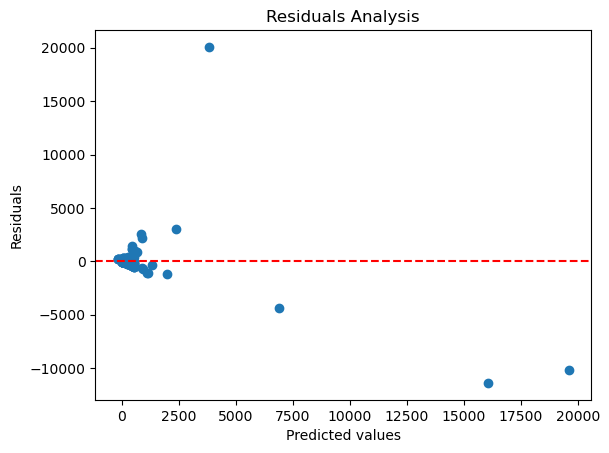

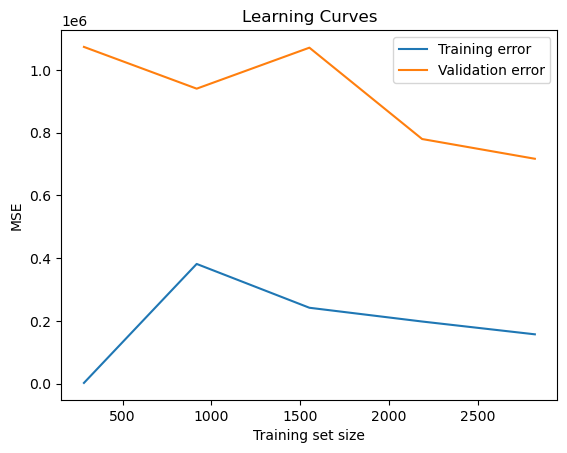

Training set RMSE: 389.9105009150084
Test set RMSE: 886.7284162097052


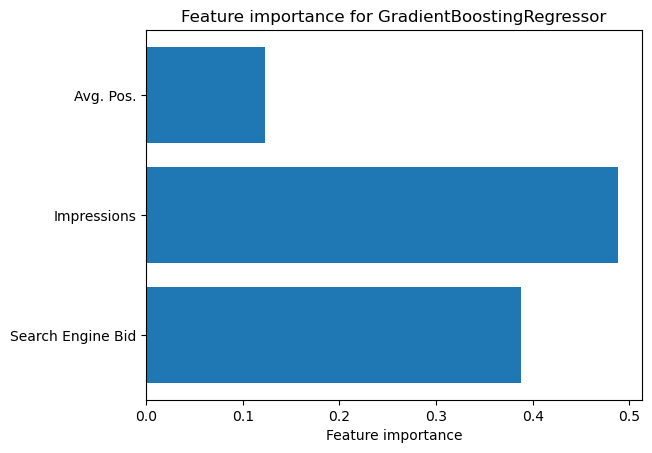

In [14]:
# Escalado de las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[['Search Engine Bid', 'Impressions', 'Avg. Pos.']])
X_test_scaled = scaler.transform(X_test[['Search Engine Bid', 'Impressions', 'Avg. Pos.']])

# Reducir el modelo para prevenir sobreajuste
param_dist_gb = {
    'n_estimators': [50, 100],  # menos estimadores
    'max_depth': [3, 4],  # profundidades menores
    'min_samples_split': [4, 6],  # aumentar para regularización
    'min_samples_leaf': [3, 4],  # aumentar para regularización
    'learning_rate': [0.05, 0.1]  # tasa de aprendizaje ligeramente más baja
}

# Buscar los mejores hiperparámetros con RandomizedSearchCV
gb_model = GradientBoostingRegressor(random_state=42)
random_search_gb = RandomizedSearchCV(
    gb_model,
    param_distributions=param_dist_gb,
    n_iter=20,  # menos iteraciones
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42
)
random_search_gb.fit(X_train_scaled, y_train)

# Evaluar el modelo ajustado en el conjunto de entrenamiento y prueba
best_gb_model = random_search_gb.best_estimator_
y_train_pred = best_gb_model.predict(X_train_scaled)
y_test_pred = best_gb_model.predict(X_test_scaled)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Analizar los residuos
residuos = y_test - y_test_pred
plt.scatter(y_test_pred, residuos)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals Analysis')
plt.show()

# Curvas de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    best_gb_model,
    X_train_scaled,
    y_train,
    cv=5,
    scoring='neg_mean_squared_error'
)

# Curvas de aprendizaje de plot
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Training error')
plt.plot(train_sizes, test_scores_mean, label='Validation error')
plt.xlabel('Training set size')
plt.ylabel('MSE')
plt.title('Learning Curves')
plt.legend()
plt.show()

# Mostrar RMSE
print(f'Training set RMSE: {train_rmse}')
print(f'Test set RMSE: {test_rmse}')

# Importancia de las características
features = ['Search Engine Bid', 'Impressions', 'Avg. Pos.']
feature_importances = best_gb_model.feature_importances_
plt.barh(features, feature_importances)
plt.xlabel('Feature importance')
plt.title('Feature importance for GradientBoostingRegressor')
plt.show()

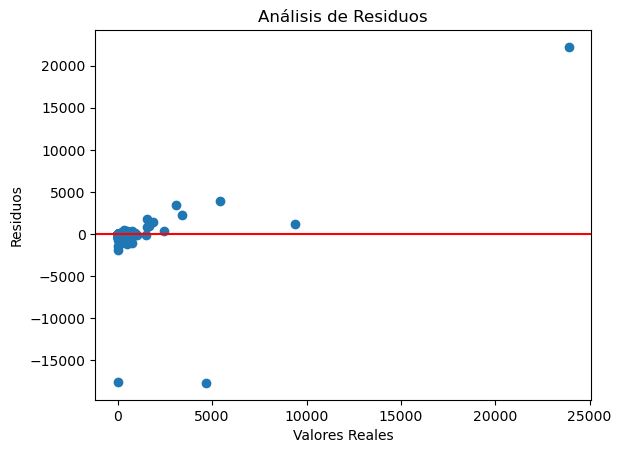

In [15]:
import matplotlib.pyplot as plt

# Cálculo de residuos
residuos = y_test - y_pred

# Gráfico de residuos
plt.scatter(y_test, residuos)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Valores Reales')
plt.ylabel('Residuos')
plt.title('Análisis de Residuos')
plt.show()


In [16]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# Suponiendo que ya tienes y_test y y_pred de tus predicciones anteriores
residuos = y_test - y_pred
df_residuos = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Residuals': residuos})
df_residuos['Absolute_Residuals'] = df_residuos['Residuals'].abs()
df_residuos_largest = df_residuos.sort_values('Absolute_Residuals', ascending=False)
print(df_residuos_largest.head())


       Actual     Predicted     Residuals  Absolute_Residuals
676   23893.0   1675.292536  22217.707464        22217.707464
184    4672.0  22348.502506 -17676.502506        17676.502506
4372     14.0  17620.414880 -17606.414880        17606.414880
2979   5393.0   1506.190904   3886.809096         3886.809096
4210   3088.0   -322.172497   3410.172497         3410.172497


In [19]:
from sklearn.model_selection import cross_val_score

# Realizar validación cruzada en el conjunto de entrenamiento
scores = cross_val_score(best_gb_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores)
print(f"Scores: {rmse_scores}")
print(f"Promedio: {rmse_scores.mean()}")
print(f"Desviación estándar: {rmse_scores.std()}")



Scores: [1188.357197    728.36919667  696.71613558 1033.15907333  296.65763429]
Promedio: 788.6518473756392
Desviación estándar: 307.79624066895536


In [11]:
from sklearn.model_selection import cross_val_score

# Asume que 'best_gb_model' es tu modelo ajustado
cv_scores = cross_val_score(best_gb_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

print("Scores de CV:", cv_scores)
print("Promedio de RMSE de CV:", np.sqrt(-cv_scores.mean()))


Scores de CV: [-1412192.82765879  -530521.68666415  -485413.37357862 -1067417.67080978
   -88005.75198341]
Promedio de RMSE de CV: 846.5874214391271


In [12]:
from sklearn.model_selection import train_test_split

# Divide tu conjunto de entrenamiento original para crear un conjunto de validación
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

# Reentrena tu modelo en el nuevo conjunto de entrenamiento y evalúalo en el conjunto de validación
best_gb_model.fit(X_train_split, y_train_split)
y_val_pred = best_gb_model.predict(X_val_split)

print("RMSE en el conjunto de validación:", np.sqrt(mean_squared_error(y_val_split, y_val_pred)))


RMSE en el conjunto de validación: 770.7148914838784


In [8]:
for column in ['Search Engine Bid', 'Impressions', 'Avg. Cost per Click', 'Avg. Pos.']:
    df_test[column] = clean_numeric_column(df_test[column])

# Asume que ya has aplicado One-Hot Encoding y otros pasos de preprocesamiento necesarios aquí

# Selecciona las mismas características usadas para entrenar el modelo
X_test_preprocessed = scaler.transform(df_test[['Search Engine Bid', 'Impressions', 'Avg. Pos.']])
# Asegúrate de aplicar el mismo escalado y preprocesamiento aquí

# Paso 2: Predicciones con el modelo entrenado
y_pred_test = best_gb_model.predict(X_test_preprocessed)

# Paso 3: Creación del archivo de envío
submission = pd.DataFrame({
    'entry_id': df_test['entry_id'],  # o el nombre correcto de tu columna de identificación
    'Clicks': y_pred_test
})

# Exporta el DataFrame a un archivo CSV
submission.to_csv('submission.csv', index=False)

In [9]:
# Ya has calculado RMSE para el conjunto de entrenamiento y prueba previamente
print(f'Training set RMSE: {train_rmse}')
print(f'Test set RMSE: {test_rmse}')

Training set RMSE: 389.9105009150084
Test set RMSE: 886.7284162097052


In [10]:
# Cargar el archivo de submission para validar su contenido
submission_check = pd.read_csv('submission.csv')
print(submission_check.head())  # Ver las primeras filas para comprobar la estructura
print("Número total de filas:", submission_check.shape[0])  # Verificar el número de filas


   entry_id       Clicks
0  mkt_4036   534.174346
1  mkt_2533 -1706.999688
2  mkt_4114   568.520158
3  mkt_3635    51.731692
4  mkt_1937  1088.118119
Número total de filas: 100
